# Detailed Text Length EDA Notebook

### Import libraries

In [1]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/1138180215.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Connect to db

In [6]:
db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db" 

conn = sqlite3.connect(db_path)

query = """
    SELECT
        d.document_id,
        f.form_name AS form,
        d.content
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
"""
df_text = pd.read_sql_query(query, conn)
conn.close()

# Text length metrics

In [7]:
df_text['length_chars'] = df_text['content'].apply(lambda x: len(x) if pd.notnull(x) else 0)
df_text['length_words'] = df_text['content'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

print("Character Length Stats:")
print(df_text['length_chars'].describe())
print("\nWord Count Stats:")
print(df_text['length_words'].describe())

Character Length Stats:
count    4.165000e+03
mean     2.491601e+05
std      8.284106e+05
min      3.100000e+01
25%      2.240800e+04
50%      5.217800e+04
75%      1.486360e+05
max      2.465296e+07
Name: length_chars, dtype: float64

Word Count Stats:
count    4.165000e+03
mean     3.485183e+04
std      1.124201e+05
min      6.000000e+00
25%      3.226000e+03
50%      7.579000e+03
75%      2.090400e+04
max      2.972533e+06
Name: length_words, dtype: float64


### Character Length analysis (similar analysis for wordcount)

- There are 4,165 documents in total.
- Median character length is 52,178, while the mean is  249,160: right-skewed distribution, with some documents being extremely long.
- The standard deviation (828,411) is very large relative to the mean, indicating high variability.
- The maximum document has nearly 24.65 million characters, which is an extreme outlier compared to the bulk of the data.

- While the typical document is moderately long, there is a subset of extremely long documents that heavily influences the mean and standard deviation, which can be excluded from our model to avoid summarising issues.

### Histogram of character lengths

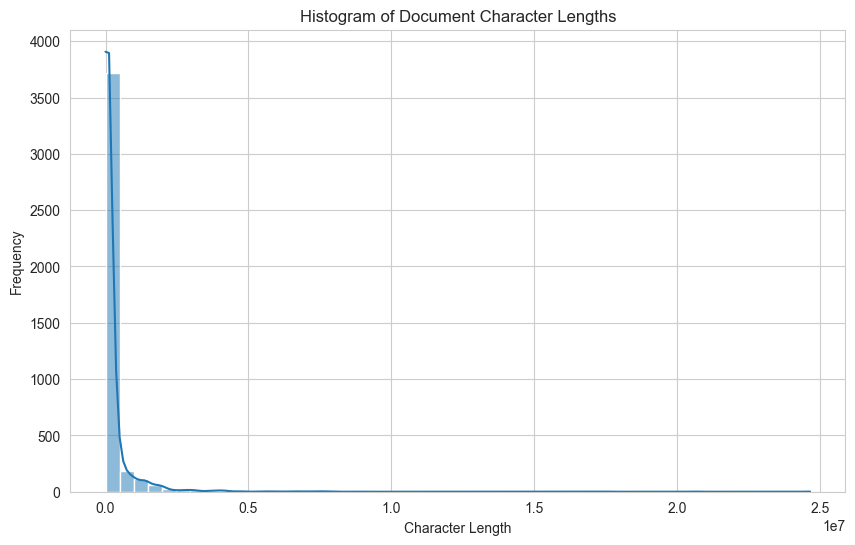

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_text['length_chars'], bins=50, kde=True)
plt.title("Histogram of Document Character Lengths")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

### Histogram of word counts

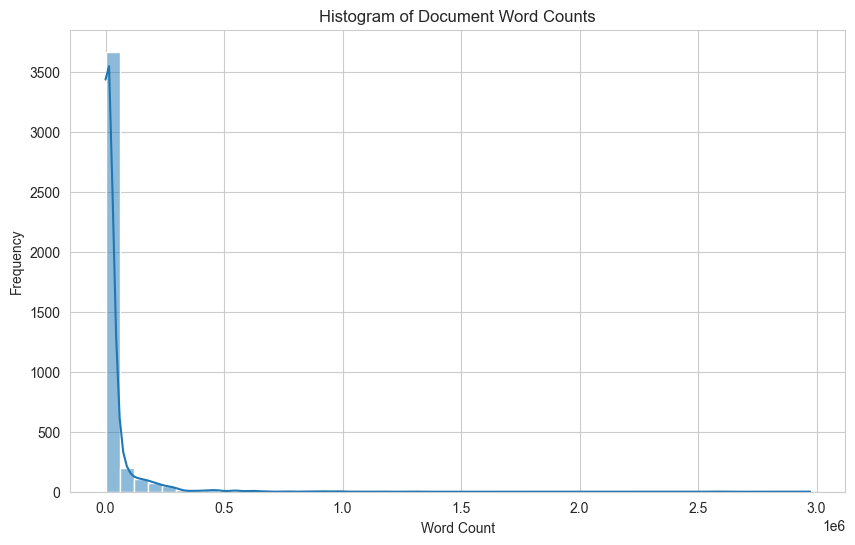

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_text['length_words'], bins=50, kde=True)
plt.title("Histogram of Document Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Natural breakpoints in the character length distribution

### Kernel density estimate (KDE) for character lengths

In [10]:
kde = gaussian_kde(df_text['length_chars'])
x_grid = np.linspace(0, df_text['length_chars'].max(), 1000)
density = kde(x_grid)

### Local maxima (peaks) in the density

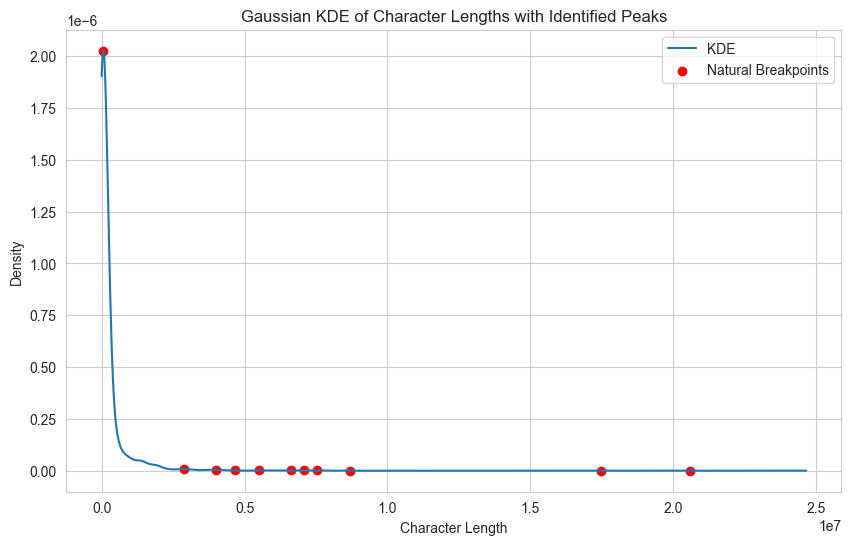

In [11]:
peaks = argrelextrema(density, np.greater)[0]
breakpoints = x_grid[peaks].astype(int)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, density, label="KDE")
plt.scatter(breakpoints, density[peaks], color='red', label="Natural Breakpoints")
plt.title("Gaussian KDE of Character Lengths with Identified Peaks")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.legend()
plt.show()

In [12]:
print("Identified Natural Breakpoints (Character Length):", breakpoints)

Identified Natural Breakpoints (Character Length): [   49355  2887283  3997777  4664073  5503113  6638284  7082482  7551357
  8686528 17471767 20581149]


- The array of breakpoints indicates multiple local maxima in the character-length distribution.
- This provides a sense of natural clusters within the data.
- The first is around 49k characters  while the others all exceed 2.8 million—showing one main cluster of “moderate” documents and multiple clusters of extremely large documents.

### Outlier thresholds (95th percentile)

In [13]:
char_threshold_95 = np.percentile(df_text['length_chars'], 95)
word_threshold_95 = np.percentile(df_text['length_words'], 95)
print(f"95th Percentile for Character Length: {char_threshold_95}")
print(f"95th Percentile for Word Count: {word_threshold_95}")

95th Percentile for Character Length: 1237060.7999999989
95th Percentile for Word Count: 166132.59999999992


- At ~1.24 million characters and ~166k words, this means 95% of documents fall below these thresholds, while the top 5% are much larger outliers.
- Documents above ~1.24 million characters can skew metrics and overwhelm standard NLP pipelines.

### Relation between document type and text length

### Boxplot of word count by document form

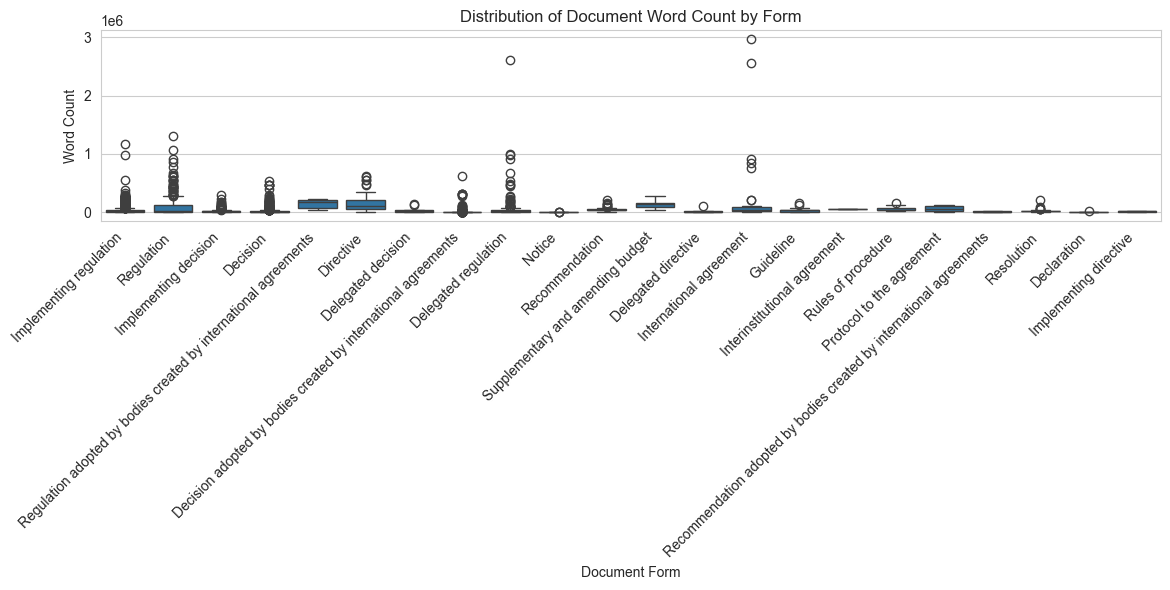

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_text, x='form', y='length_words')
plt.title("Distribution of Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Barplot: Average word count by document form

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


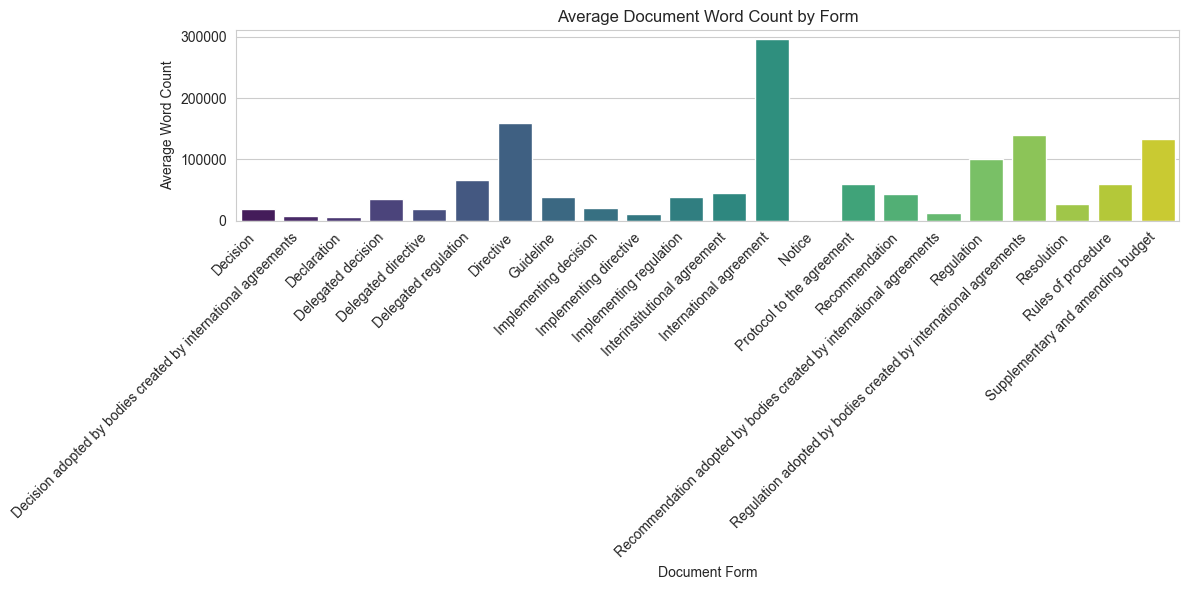

In [15]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Metrics for each form type

In [17]:
metrics_by_form = df_text.groupby('form').agg(
    word_mean=('length_words', 'mean'),
    word_median=('length_words', 'median'),
    word_std=('length_words', 'std'),
    word_min=('length_words', 'min'),
    word_max=('length_words', 'max'),
    word_count=('length_words', 'count'),
    word_25th=('length_words', lambda x: np.percentile(x, 25)),
    word_75th=('length_words', lambda x: np.percentile(x, 75)),
    char_mean=('length_chars', 'mean'),
    char_median=('length_chars', 'median'),
    char_std=('length_chars', 'std'),
    char_min=('length_chars', 'min'),
    char_max=('length_chars', 'max'),
    char_count=('length_chars', 'count'),
    char_25th=('length_chars', lambda x: np.percentile(x, 25)),
    char_75th=('length_chars', lambda x: np.percentile(x, 75)),
    char_95th=('length_chars', lambda x: np.percentile(x, 95))
).reset_index()

print(metrics_by_form)


                                                 form      word_mean  \
0                                            Decision   18808.389966   
1   Decision adopted by bodies created by internat...    6983.792157   
2                                         Declaration    6108.400000   
3                                  Delegated decision   34861.818182   
4                                 Delegated directive   19655.272727   
5                                Delegated regulation   65777.104072   
6                                           Directive  159585.216667   
7                                           Guideline   37976.375000   
8                               Implementing decision   21209.246073   
9                              Implementing directive   11239.666667   
10                            Implementing regulation   38440.638554   
11                       Interinstitutional agreement   45980.000000   
12                            International agreement  295387.71

In [25]:
%pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import openpyxl
metrics_by_form.to_excel("metrics_by_form.xlsx", index=False)

/Users/alexanderbenady/DataThesis/eu-legal-recommender/notebooks/metrics_by_form.xlsx

### Analysis of text by form type

**International agreement**
- Word counts: Mean ≈295.4k, Median ≈40.4k
- Character counts: Mean ≈2.04M, Median ≈260.7k, 95th percentile ≈11.36M, Max ≈20.58M
- Extreme right skew with a few exceptionally long documents.
- Exclude whole FORM?

In [30]:
df_intl = df_text[df_text['form'] == 'International agreement'].copy()

df_intl['word_count'] = df_intl['content'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

intl_char_90th = np.percentile(df_intl['length_chars'], 90)
intl_word_90th = np.percentile(df_intl['length_words'], 90)

print("Number of International agreement documents:", len(df_intl))

print("International agreement - 90th Percentile of character length:", intl_char_90th)
print("International agreement - 90th Percentile of word count:", intl_word_90th)

Number of International agreement documents: 32
International agreement - 90th Percentile of character length: 5833715.000000001
International agreement - 90th Percentile of word count: 835737.4000000001


In [40]:
intl_over_500k = df_intl[df_intl['length_words'] > 500000].shape[0]
print("Number of files with more than 500,000 words:", intl_over_500k) # This could be a cutoff point

Number of files with more than 500,000 words: 5


**Decision**
- Word counts: Mean ≈18.8k, Median = 5.7k, 25th–75th: 3.7k–14.1k
- Character counts: Mean ≈130k, Median ≈38.8k, 95th percentile ≈498k, Maximum ≈4.67M
- A strong right skew exists, most relatively short.
- Identify OUTLIERS!

**Delegated decision**
- Word counts: Mean ≈34.9k, Median = 12.3k
- Character counts: Mean ≈370k, Median ≈81k, 95th percentile ≈1.50M
- There is significant skew: a few very long documents are pushing the mean upward.
- Identify OUTLIERS!

**Delegated regulation**
- Word counts: Mean ≈65.8k, Median ≈16.1k, Max ≈2.61M
- Character counts: Mean ≈496k, Median ≈112k, 95th percentile ≈1.59M, Max ≈24.65M
- This category shows extreme outliers. A few very long documents drive up the mean and maximum values.
- Identify OUTLIERS!

**Directive**
- Word counts: Mean ≈159.6k, Median ≈103.2k
- Character counts: Mean ≈1.08M, Median ≈692.9k, 95th percentile ≈3.70M
- Although these documents are generally long, the spread is wide.
- Identify OUTLIERS!

**Implementing decision**
- Word counts: Mean ≈21.2k, Median ≈10.9k
- Character counts: Mean ≈177.8k, Median ≈76.9k, 95th percentile ≈647.9k
- Large sample with some skew.
- Identify OUTLIERS!

**Implementing regulation**
- Word counts: Mean ≈38.4k, Median ≈12.0k, Max ≈1.16M
- Character counts: Mean ≈279.6k, Median ≈86.4k, 95th percentile ≈1.40M, Max ≈7.62M
- Significant right skew and extreme outliers are present
- Identify OUTLIERS!

**Regulation**
- Word counts: Mean ≈101k, Median ≈24.8k
- Character counts: Mean ≈695k, Median ≈185.7k, 95th percentile ≈3.16M, Max ≈8.70M
- Very long documents in the upper tail.
- Identify OUTLIERS!

**Regulation adopted by bodies created by international agreements**
- Word counts: Mean ≈139.9k, Median ≈178.8k
- Character counts: Mean ≈956.5k, Median ≈1.21M, 95th percentile ≈1.50M
- Small sample (9 documents) with relatively consistent numbers
- Likely acceptable without exclusion.


**Protocol to the agreement**
- Word counts: Mean ≈59.3k, Median ≈47.3k
- Character counts: Mean ≈399.6k, Median ≈333k, 95th percentile ≈826k
- Small sample (8 documents) with moderate lengths
- Some variability, but the 95th percentile is not too extreme relative to the median.
- Look into it.

**Guideline**
- Word counts: Mean ≈38k, Median ≈31.8k
- Character counts: Mean ≈257k, Median ≈217k, 95th percentile ≈830k
- Moderate variability is observed, with fewer extreme outliers.
- Standard processing should be fine.

**Recommendation**
- Word counts: Mean ≈43.4k, Median ≈34.3k
- Character counts: Mean ≈308.4k, Median ≈242.3k, 95th percentile ≈837.5k
- Moderate skew is present, but not overly extreme.
- Standard processing should be fine.

**Resolution**
- Word counts: Mean ≈26.6k, Median ≈18.7k
- Character counts: Mean ≈176.3k, Median ≈127.1k, 95th percentile ≈341.4k
- Moderate skew; differences between mean and median exist but are not as drastic as in some other forms.
- Standard processing should be fine.

**Rules of procedure**
- Word counts: Mean ≈59.6k, Median ≈36.3k
- Character counts: Mean ≈378.9k, Median ≈230.3k, 95th percentile ≈830k
- Variability is moderate and outliers are not extreme.

**Supplementary and amending budget**
- Word counts: Mean ≈133.7k, Median ≈134.2k (high consistency)
- Character counts: Mean ≈884.8k, Median ≈879.5k, 95th percentile ≈1.62M
- High consistency between mean and median.
- Standard processing should be fine.


**Delegated directive**
- Word counts: Mean ≈19.7k, Median ≈9.95k
- Character counts: Mean ≈150k, Median ≈65.8k, 95th percentile ≈514k
- Moderate skew exists, extreme cases are not too far from the 95th percentile.
- Should be fine to process.

**Declaration**
- Only 5 documents, with a median of 2.4k words and 15.9k characters.
- Short length, no outliers.

**Decision adopted by bodies created by international agreements**
- Word counts: Mean ≈7k, Median ≈2.7k, 25th–75th: 2.1k–4.1k
- Character counts: Mean ≈49k, Median ≈18.7k, 95th percentile ≈96k
- Shorter and more consistent in length, no outliers.

**Implementing directive**
- Only 3 documents; lengths are very consistent.

**Interinstitutional agreement**
- Single document only, short length. 

**Notice**
- Word counts: Mean ≈772, Median ≈688.5
- Character counts: Mean ≈5.31k, Median ≈4.91k, 95th percentile ≈8.28k
- Very consistent and short documents.

**Recommendation adopted by bodies created by international agreements**
- Very small sample (3 documents), with consistent lengths.

In [41]:
count_over_500k = df_text.groupby('form').apply(lambda x: (x['length_words'] > 500000).sum()).reset_index(name='count_over_500k')
print(count_over_500k)

                                                 form  count_over_500k
0                                            Decision                1
1   Decision adopted by bodies created by internat...                1
2                                         Declaration                0
3                                  Delegated decision                0
4                                 Delegated directive                0
5                                Delegated regulation                6
6                                           Directive                4
7                                           Guideline                0
8                               Implementing decision                0
9                              Implementing directive                0
10                            Implementing regulation                3
11                       Interinstitutional agreement                0
12                            International agreement                5
13    

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/724406841.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  count_over_500k = df_text.groupby('form').apply(lambda x: (x['length_words'] > 500000).sum()).reset_index(name='count_over_500k')


- 17                                         Regulation               15
- 5                                Delegated regulation                6
- 12                            International agreement                5
- 6                                           Directive                4
- 10                            Implementing regulation                3
- 0                                            Decision                1
- 1   Decision adopted by bodies created by internat...                1

### These documents could be excluded from the summariser, and be handled manually. I want to see if it makes a difference

In [43]:
forms_to_include = [
    "Regulation",
    "Delegated regulation",
    "International agreement",
    "Directive",
    "Implementing regulation",
    "Decision",
    "Decision adopted by bodies created by international agreements"
]

df_subset = df_text[df_text['form'].isin(forms_to_include)]

df_subset_filtered = df_subset[df_subset['length_words'] < 500000].copy()

metrics_by_form_subset_filtered = df_subset_filtered.groupby('form').agg(
    word_mean=('length_words', 'mean'),
    word_median=('length_words', 'median'),
    word_std=('length_words', 'std'),
    word_min=('length_words', 'min'),
    word_max=('length_words', 'max'),
    word_count=('length_words', 'count'),
    word_25th=('length_words', lambda x: np.percentile(x, 25)),
    word_75th=('length_words', lambda x: np.percentile(x, 75)),
    char_mean=('length_chars', 'mean'),
    char_median=('length_chars', 'median'),
    char_std=('length_chars', 'std'),
    char_min=('length_chars', 'min'),
    char_max=('length_chars', 'max'),
    char_count=('length_chars', 'count'),
    char_25th=('length_chars', lambda x: np.percentile(x, 25)),
    char_75th=('length_chars', lambda x: np.percentile(x, 75)),
    char_95th=('length_chars', lambda x: np.percentile(x, 95))
).reset_index()

print(metrics_by_form_subset_filtered)


                                                form      word_mean  \
0                                           Decision   18226.908676   
1  Decision adopted by bodies created by internat...    6386.256133   
2                               Delegated regulation   36452.837209   
3                                          Directive  129659.142857   
4                            Implementing regulation   35843.245720   
5                            International agreement   51934.888889   
6                                         Regulation   70866.140065   

   word_median       word_std  word_min  word_max  word_count  word_25th  \
0       5718.0   45695.907077         6    472458         876    3675.75   
1       2690.0   24199.700830       152    307307        1019    2116.00   
2      15714.0   66772.868002         6    479902         215    7248.50   
3      94995.5  109601.468856      5117    488510          56   56639.25   
4      11939.0   58916.487911         6    384802  

- Excluding documents with 500,000+ words makes a significant difference in the aggregated metrics—especially for forms like International agreement where a few files are extremely long 
- **International agreement**:
- Before (full data): Mean word count was around 295,400, with a median around 40,400.
- After filtering: Mean word count drops dramatically to about 51,935 with a median of 36,524.

# Stats if we exclude +500,000 word files

In [48]:
df_filtered = df_text[df_text['length_words'] < 500000].copy()

print("Word Count Stats (for documents < 500k words):")
print(df_filtered['length_words'].describe())

kde = gaussian_kde(df_filtered['length_chars'])
x_grid = np.linspace(0, df_filtered['length_chars'].max(), 1000)
density = kde(x_grid)

peaks = argrelextrema(density, np.greater)[0]
breakpoints = x_grid[peaks].astype(int)
print("\nIdentified Natural Breakpoints (Character Length) for documents <500k words:", breakpoints)

char_threshold_90 = np.percentile(df_filtered['length_chars'], 90)
word_threshold_90 = np.percentile(df_filtered['length_words'], 90)
char_threshold_95 = np.percentile(df_filtered['length_chars'], 95)
word_threshold_95 = np.percentile(df_filtered['length_words'], 95)
print(f"\n90th Percentile for Character Length (filtered): {char_threshold_90}")
print(f"90th Percentile for Word Count (filtered): {word_threshold_90}")
print(f"\n95th Percentile for Character Length (filtered): {char_threshold_95}")
print(f"95th Percentile for Word Count (filtered): {word_threshold_95}")

Word Count Stats (for documents < 500k words):
count      4130.000000
mean      27481.332930
std       57569.545601
min           6.000000
25%        3204.750000
50%        7453.500000
75%       20129.000000
max      488510.000000
Name: length_words, dtype: float64

Identified Natural Breakpoints (Character Length) for documents <500k words: [  44219 1362776 1788895 2307474 2797913 3047153 3790851 4011951]

90th Percentile for Character Length (filtered): 487852.1
90th Percentile for Word Count (filtered): 68588.5

95th Percentile for Character Length (filtered): 1049931.1999999993
95th Percentile for Word Count (filtered): 150131.69999999998


In [45]:
df_excluded = df_text[df_text['length_words'] >= 500000]
print("\nDocuments with 500,000+ words (IDs for exclusion):")
print(df_excluded[['document_id', 'length_words']])


Documents with 500,000+ words (IDs for exclusion):
      document_id  length_words
47             48        553196
48             49        601165
82             83       2606533
305           306        555000
525           526        603402
951           952        615873
1142         1143        671206
1337         1338        976613
1532         1533       1164857
1872         1873       2972533
1874         1875        915343
1914         1915        855955
1921         1922        624831
1924         1925        615463
1985         1986        974676
2145         2146        844407
2237         2238       1302039
2833         2834        621454
2835         2836       1064775
2839         2840        544377
2841         2842        551776
2908         2909        528186
2909         2910        914845
3036         3037        541397
3054         3055       2560171
3063         3064        501739
3075         3076        667551
3400         3401        536513
3771         3772   

In [46]:
df_excluded.to_excel("df_excluded.xlsx", index=False)

- 35 documents were removed (extreme outliers)
- The mean drops by 7,370 words.
- Standard Deviation: Full: ~112,420, Filtered: ~57,570
- Maximum: Full: Nearly 2.97 million words, Filtered: 488,510 words
- Excluding the extreme outliers provides a more representative measure of central tendency (mean drops closer to the median) and reduces the overall variability, making the dataset less skewed. It also simplifies the NLP processing.
- However, many files are still of excessive length.

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


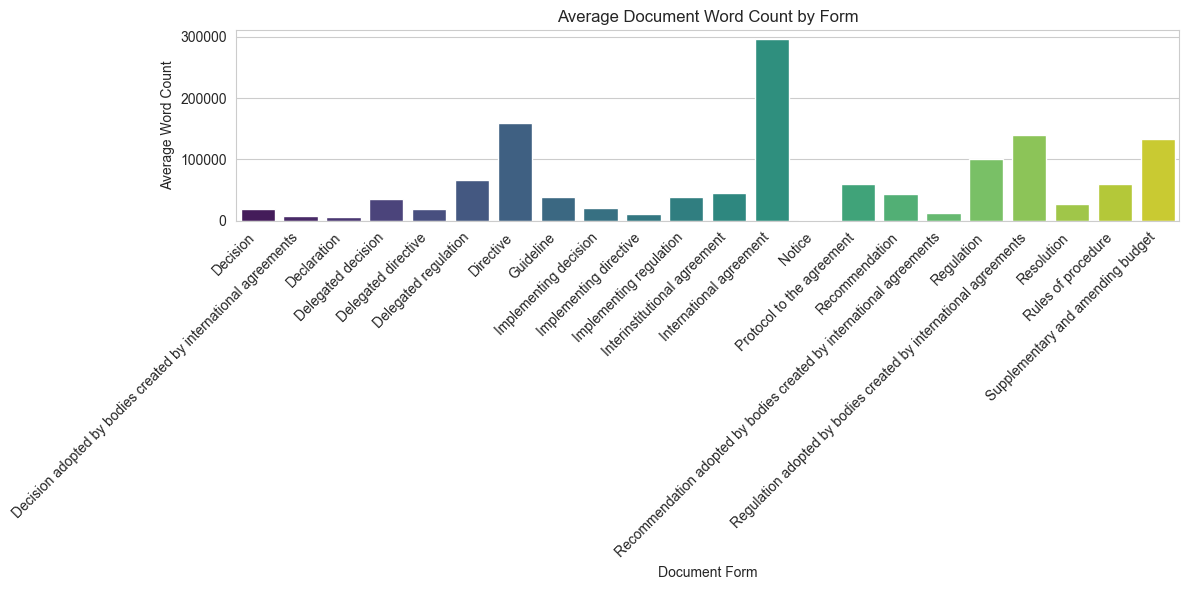

In [ ]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


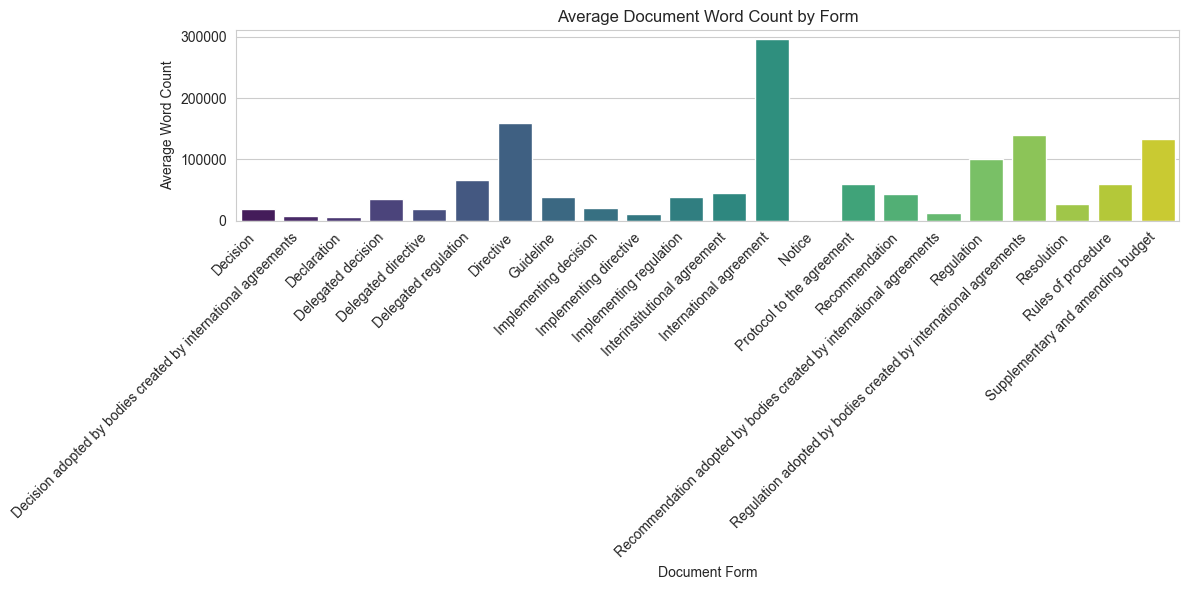

In [ ]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


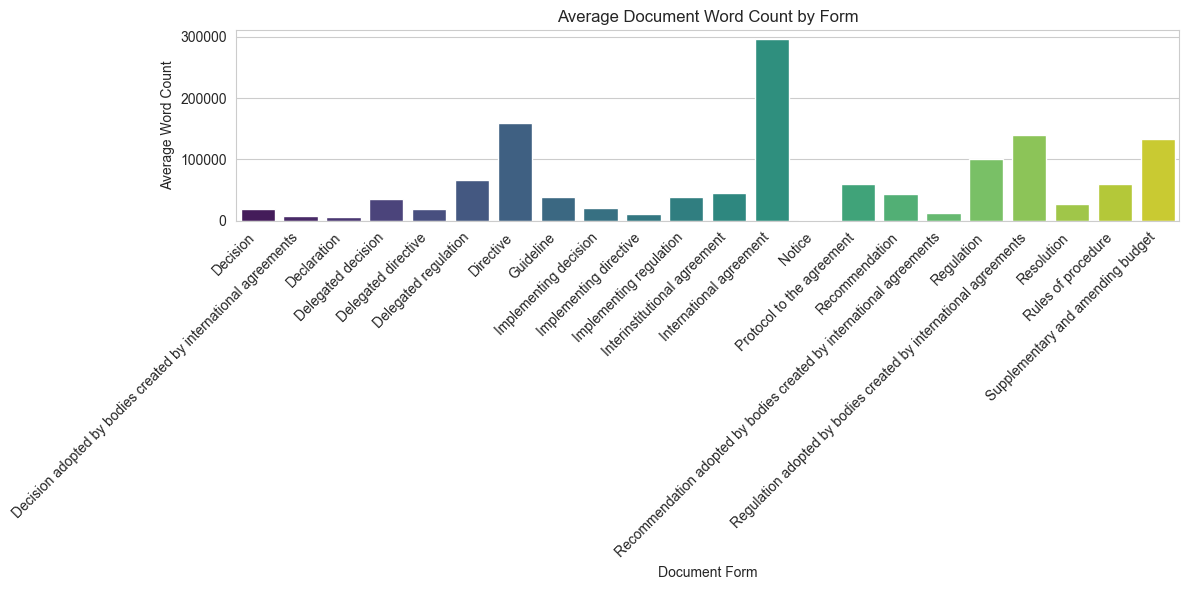

In [ ]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analysis on the Reference Dataset for Summariser Training

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


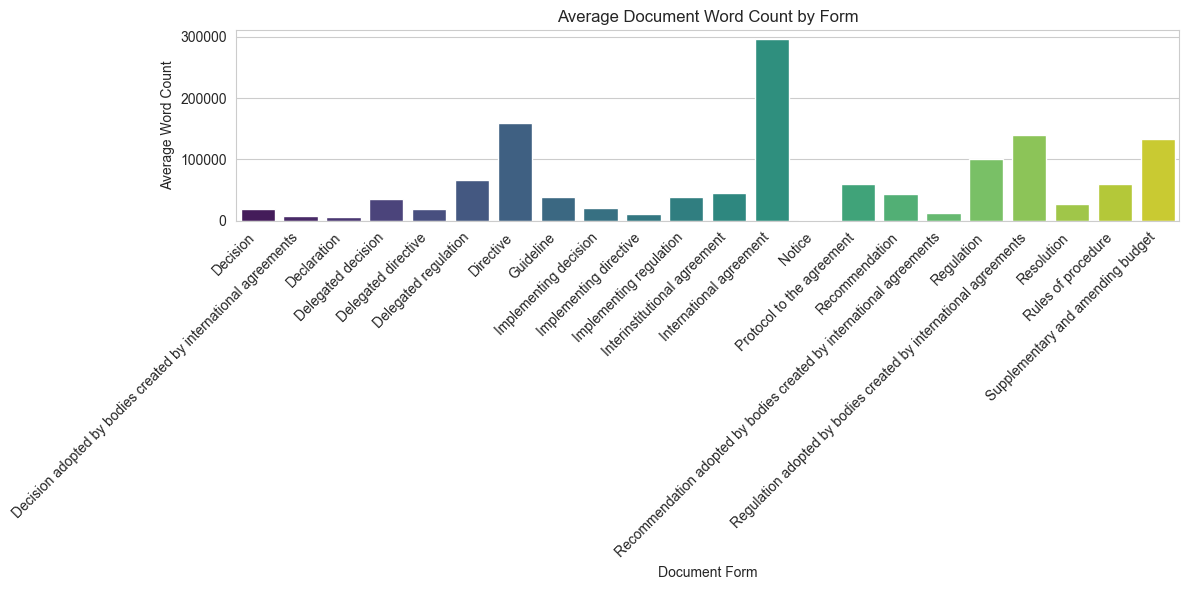

In [ ]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_75752/394677687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


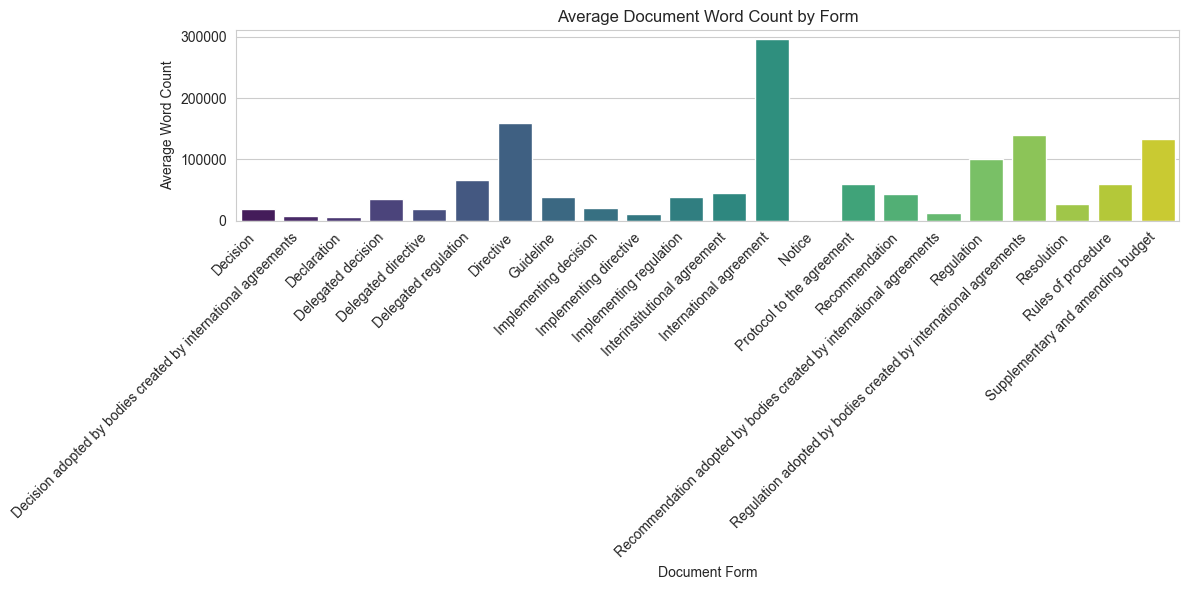

In [ ]:
avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Document Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Load reference dataset (for summariser training) from Hugging Face Datasets
from datasets import load_dataset

ds = load_dataset("dennlinger/eur-lex-sum")
df_human = pd.DataFrame({
    'doc_length': [len(d) for d in ds['train']['document']],
    'summ_length': [len(s) for s in ds['train']['summary']]
})

print("Reference Dataset - Document Length Stats:")
print(df_human['doc_length'].describe())
print("\nReference Dataset - Summary Length Stats:")
print(df_human['summ_length'].describe())

# %%
# Plot histograms for the reference dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df_human['doc_length'], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Reference Dataset: Document Length Distribution")
ax[0].set_xlabel("Document Length (characters)")

sns.histplot(df_human['summ_length'], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Reference Dataset: Summary Length Distribution")
ax[1].set_xlabel("Summary Length (characters)")

plt.tight_layout()
plt.show()